# File and libraries

In [90]:
import pandas as pd
import numpy as np




filepath=r'dataset/df_ecom_2_6_bal_input'
test_filepath= f"{filepath}_test.csv"
train_filepath= f"{filepath}_train.csv"

sample_filepath=f"{filepath}_sample.csv"
test_sample_filepath=f"{filepath}_test_sample.csv"
train_sample_filepath=f"{filepath}_train_sample.csv"

file_tag = "Multicategory Store"

# DSLabs functions

In [5]:
%run "dslabs_functions.py"


dslabs_functions lodaded


# Data functions

In [6]:
%run "data_functions.py"


data_functions loaded


# Load

In [91]:

# test_data=True
test_data=False

# use to evaluate strategies. otherwise False to just transform data 
evaluate=True
# evaluate=False

if test_data==True:

    df=pd.read_csv(f"{filepath}.csv")
    
    test= pd.read_csv(test_filepath)
    train= pd.read_csv(train_filepath)

    # sample to test setup
    df = df.groupby('day').apply(lambda x: sample_per_day(x, 0.01)).reset_index(drop=True)
    test = test.groupby('day').apply(lambda x: sample_per_day(x, 0.01)).reset_index(drop=True)
    train = train.groupby('day').apply(lambda x: sample_per_day(x, 0.01)).reset_index(drop=True)

    
    
else:
    df=pd.read_csv(f"{filepath}.csv")  
    test= pd.read_csv(test_filepath)
    train= pd.read_csv(train_filepath)

    # use 10% sample file when heavy processing
    # data=pd.read_csv(sample_filepath)
    # test= pd.read_csv(test_sample_filepath)
    # train= pd.read_csv(train_sample_filepath)
 
target='is_purchase'
taget_metric_2='precision'
taget_metric='f2'
vars: list[str] = df.columns.to_list()
labels: list = list(df[target].unique())


# ensure sorting by day_of_year for correct splitting 
# "When in the presence of temporal data, data partition shall use older data to train and newer to test, in order to not use future data to classify past data. In any other case, partition shall be random."
df.sort_values(by='day', inplace=True)
test.sort_values(by='day', inplace=True)
train.sort_values(by='day', inplace=True)



df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 235411 entries, 0 to 235410
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   category_code_lvl_1  235411 non-null  float64
 1   category_code_lvl_2  235411 non-null  float64
 2   price                235411 non-null  float64
 3   is_purchase          235411 non-null  int64  
 4   activity_in_session  235411 non-null  float64
 5   week_of_month        235411 non-null  int64  
 6   day                  235411 non-null  int64  
 7   brand_value          235411 non-null  float64
 8   product_category     235411 non-null  int64  
 9   day_of_week_sin      235411 non-null  float64
 10  day_of_week_cos      235411 non-null  float64
 11  hour_sin             235411 non-null  float64
 12  hour_cos             235411 non-null  float64
dtypes: float64(9), int64(4)
memory usage: 25.1 MB


# Distribution Check

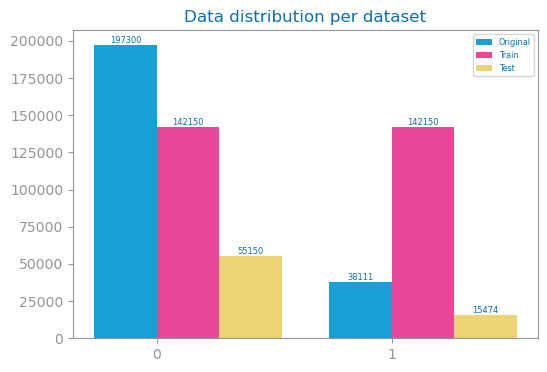

In [92]:
from pandas import concat
from matplotlib.pyplot import figure, show
from dslabs_functions import plot_multibar_chart


# Distribution check


# Create a dictionary to store original class counts
values: dict[str, list[int]] = {
    "Original": [
        len(df[df[target] == 0]),  # Assuming 0 is the negative class
        len(df[df[target] == 1]),  # Assuming 1 is the positive class
    ]
}

values["Train"] = [
    len(train[train[target] == 0]),
    len(train[train[target] == 1]),
]
values["Test"] = [
    len(test[test[target] == 0]),
    len(test[test[target] == 1]),
]

# Visualize the distribution
figure(figsize=(6, 4))
plot_multibar_chart(labels, values, title="Data distribution per dataset")
show()

# Model Evaluation

In [6]:

from typing import Union
import pandas as pd
from pandas import DataFrame
from numpy import array, ndarray

# adapted to read from memory
def read_train_test_from_files(
    train_fn: Union[str, DataFrame], test_fn: Union[str, DataFrame], target: str = "class"
) -> tuple[ndarray, ndarray, array, array, list, list]:
    """
    Reads training and test data from either CSV files or DataFrames, and splits
    the data into features and target.

    Parameters:
    -----------
    train_fn : Union[str, DataFrame]
        File path to the training CSV or a DataFrame object.
    test_fn : Union[str, DataFrame]
        File path to the test CSV or a DataFrame object.
    target : str, default="class"
        The name of the target column.

    Returns:
    --------
    tuple : (trnX, tstX, trnY, tstY, labels, features)
        - trnX: Training feature set as ndarray.
        - tstX: Test feature set as ndarray.
        - trnY: Training labels as array.
        - tstY: Test labels as array.
        - labels: List of unique target values.
        - features: List of feature names (column names).
    """
    # Check if train_fn is a string (file path) or DataFrame, and handle accordingly
    if isinstance(train_fn, str):
        train: DataFrame = pd.read_csv(train_fn, index_col=None)
    else:
        train: DataFrame = train_fn.copy()  # Use the provided DataFrame directly

    # Extract and sort unique target labels
    labels: list = list(train[target].unique())
    labels.sort()

    # Separate features (X) and target (Y) for training data
    trnY: array = train.pop(target).to_list()
    trnX: ndarray = train.values

    # Check if test_fn is a string (file path) or DataFrame, and handle accordingly
    if isinstance(test_fn, str):
        test: DataFrame = pd.read_csv(test_fn, index_col=None)
    else:
        test: DataFrame = test_fn.copy()  # Use the provided DataFrame directly

    # Separate features (X) and target (Y) for test data
    tstY: array = test.pop(target).to_list()
    tstX: ndarray = test.values

    return trnX, tstX, trnY, tstY, labels, train.columns.to_list()



In [93]:
from typing import Union
import pandas as pd
from pandas import DataFrame
from numpy import array, ndarray

# Função para ler os dados de treino e teste
def read_train_test_from_files(
    train_fn: Union[str, DataFrame], test_fn: Union[str, DataFrame], target: str = "class"
) -> tuple[ndarray, ndarray, array, array, list, list]:
    """
    Lê dados de treino e teste de arquivos CSV ou DataFrames e separa as características e o alvo.

    (Documentação da função...)
    """
    # Verificar se train_fn é uma string (caminho do arquivo) ou DataFrame, e tratar conforme necessário
    if isinstance(train_fn, str):
        train: DataFrame = pd.read_csv(train_fn, index_col=None)
    else:
        train: DataFrame = train_fn.copy()  # Usar o DataFrame fornecido diretamente

    # Extrair e ordenar os rótulos de alvo únicos
    labels: list = list(train[target].unique())
    labels.sort()

    # Separar características (X) e alvo (Y) para dados de treino
    trnY: array = train.pop(target).to_list()
    trnX: ndarray = train.values

    # Verificar se test_fn é uma string (caminho do arquivo) ou DataFrame, e tratar conforme necessário
    if isinstance(test_fn, str):
        test: DataFrame = pd.read_csv(test_fn, index_col=None)
    else:
        test: DataFrame = test_fn.copy()  # Usar o DataFrame fornecido diretamente

    # Separar características (X) e alvo (Y) para dados de teste
    tstY: array = test.pop(target).to_list()
    tstX: ndarray = test.values

    return trnX, tstX, trnY, tstY, labels, train.columns.to_list()

# Exemplo de uso da função
if evaluate == True:
    # Verifica o tipo de train e test
    print(f'Train: {train}, type: {type(train)}')  # Verifica o tipo de train
    print(f'Test: {test}, type: {type(test)}')      # Verifica o tipo de test

    # Lê os dados usando a função
    trnX, tstX, trnY, tstY, labels, vars = read_train_test_from_files(train, test, target)

    # Exibe as informações lidas
    print(f'Train#={len(trnX)} Test#={len(tstX)}')
    print(f'Labels={labels}')


Train:         category_code_lvl_1  category_code_lvl_2        price  \
0                       0.0                  3.0   949.470000   
2163                    0.0                  3.0   272.320000   
2164                    0.0                  3.0  1000.770000   
2165                    0.0                  3.0   722.400000   
2166                    0.0                  3.0   139.680000   
...                     ...                  ...          ...   
281138                  2.0                 15.0   216.001578   
281137                  0.0                  1.0   153.050000   
281136                  7.0                 47.0    61.780000   
281134                  9.0                 56.0   360.110000   
284299                  0.0                  3.0   741.330000   

        activity_in_session  week_of_month   day  brand_value  \
0                   3.00000            1.0   1.0        779.2   
2163                3.00000            1.0   1.0        282.5   
2164             

In [94]:
if evaluate==True:
    
    trnX, tstX, trnY, tstY, labels, vars = read_train_test_from_files(train, test, target)
    print(f'Train#={len(trnX)} Test#={len(tstX)}')
    print(f'Labels={labels}')

Train#=284300 Test#=70624
Labels=[0, 1]


## d max definition

In [79]:
d_max_eval= 20

# recall

## recall study

DT best with gini and d=4


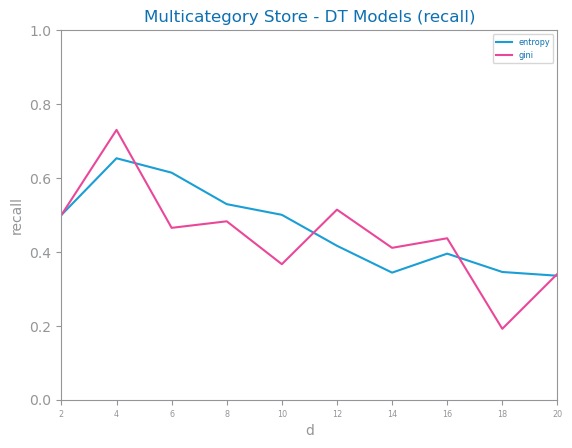

In [80]:
if evaluate==True:

    best_model_recall, recall_params = trees_study(trnX, trnY, tstX, tstY, d_max=d_max_eval, metric='recall', file_tag=file_tag)
    savefig(f'images/{file_tag}_dt_recall_study.png')
    show()

## recall model evaluation

In [ ]:
prd_trn: array = best_model_recall.predict(trnX)
prd_tst: array = best_model_recall.predict(tstX)
figure()
plot_evaluation_results(recall_params, trnY, prd_trn, tstY, prd_tst, labels, file_tag=file_tag)
savefig(f'images/{file_tag}_dt_{recall_params["name"]}_best_{recall_params["metric"]}_eval.png')
show()

<Figure size 640x480 with 0 Axes>

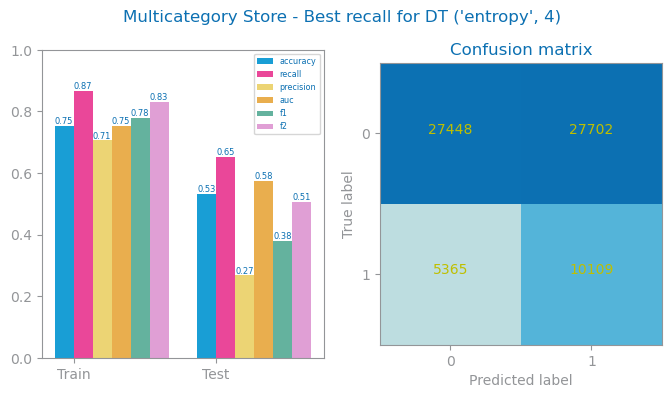

In [64]:
prd_trn: array = best_model_recall.predict(trnX)
prd_tst: array = best_model_recall.predict(tstX)
figure()
plot_evaluation_results(recall_params, trnY, prd_trn, tstY, prd_tst, labels, file_tag=file_tag)
savefig(f'images/{file_tag}_dt_{recall_params["name"]}_best_{recall_params["metric"]}_eval.png')
show()

<Figure size 640x480 with 0 Axes>

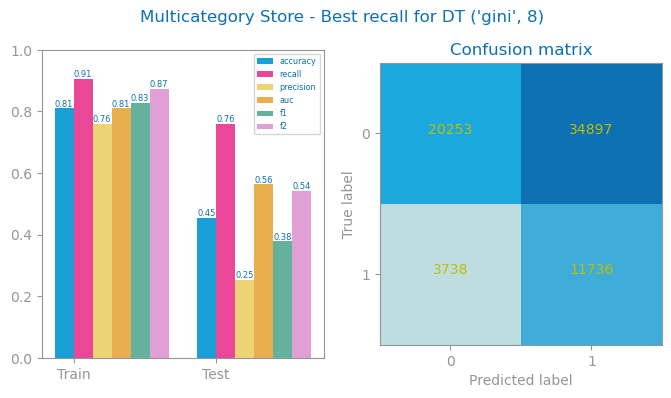

In [33]:
prd_trn: array = best_model_recall.predict(trnX)
prd_tst: array = best_model_recall.predict(tstX)
figure()
plot_evaluation_results(recall_params, trnY, prd_trn, tstY, prd_tst, labels, file_tag=file_tag)
savefig(f'images/{file_tag}_dt_{recall_params["name"]}_best_{recall_params["metric"]}_eval.png')
show()

<Figure size 640x480 with 0 Axes>

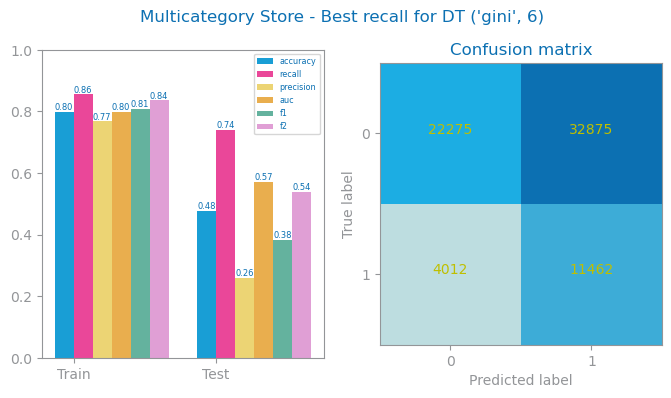

In [12]:
prd_trn: array = best_model_recall.predict(trnX)
prd_tst: array = best_model_recall.predict(tstX)
figure()
plot_evaluation_results(recall_params, trnY, prd_trn, tstY, prd_tst, labels, file_tag=file_tag)
savefig(f'images/{file_tag}_dt_{recall_params["name"]}_best_{recall_params["metric"]}_eval.png')
show()

Nós queremos obter o minimo numero de falsos positivos, tendo claro sempre uma quantitade alta de TRu positives. para impactar os clientes que vão comprar.
Testámos 3 ginis - 4, 6 , 8. 
O gini 6, foi o nivel de gini que nos deu menor numero de falsos positivos com um nivel consideravel de true positives, ou seja, teve a precision maior, mantendo na mesma um score alto de recall.

We aim to achieve the minimum number of false positives while maintaining a high number of true positives. This enable us to effectively target customers who are likely to purchase (Tru positives). And This approach also helps reduce the budget spent on users we believed would buy but ultimately do not (False Positives). We tested three Gini values: 4, 6, and 8. The Gini value of 4 provided the lowest number of false positives with a substantial level of true positives, resulting in the highest precision while still maintaining a high recall score.


-> Recall DT best with entropy and d=4

# precision

## precision study

In [168]:
d_max_eval= 12

DT best with gini and d=6


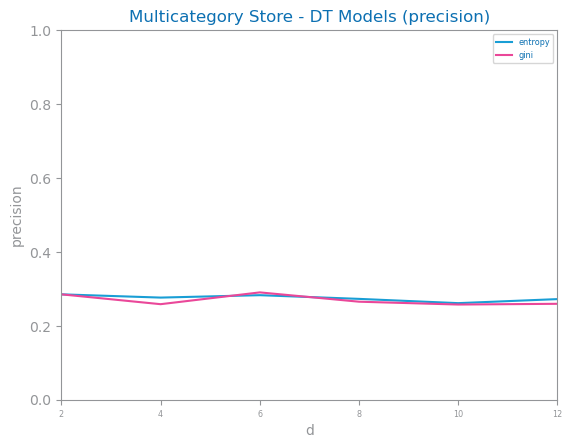

In [169]:
best_model_prec, prec_params = trees_study(trnX, trnY, tstX, tstY, d_max=d_max_eval, metric='precision', file_tag=file_tag)
savefig(f'images/{file_tag}_dt_{prec_params["metric"]}_study.png')
show()

## precision model evaluation

<Figure size 640x480 with 0 Axes>

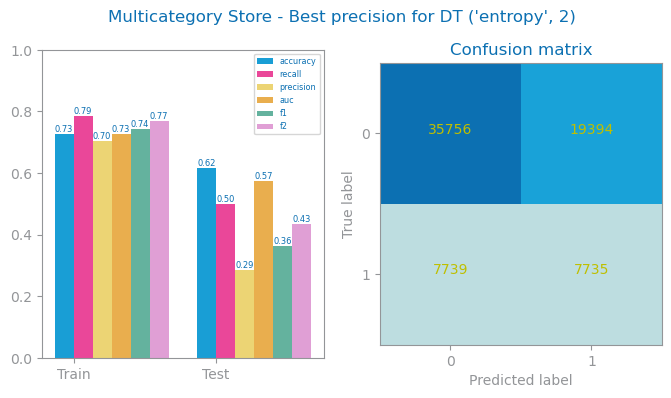

In [127]:
prd_trn: array = best_model_prec.predict(trnX)
prd_tst: array = best_model_prec.predict(tstX)
figure()
plot_evaluation_results(prec_params, trnY, prd_trn, tstY, prd_tst, labels, file_tag=file_tag)
savefig(f'images/{file_tag}_dt_{prec_params["name"]}_best_{prec_params["metric"]}_eval.png')
show()

<Figure size 640x480 with 0 Axes>

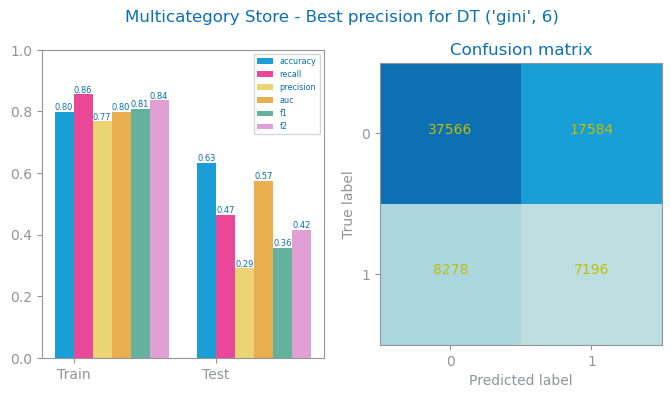

In [124]:
prd_trn: array = best_model_prec.predict(trnX)
prd_tst: array = best_model_prec.predict(tstX)
figure()
plot_evaluation_results(prec_params, trnY, prd_trn, tstY, prd_tst, labels, file_tag=file_tag)
savefig(f'images/{file_tag}_dt_{prec_params["name"]}_best_{prec_params["metric"]}_eval.png')
show()

<Figure size 640x480 with 0 Axes>

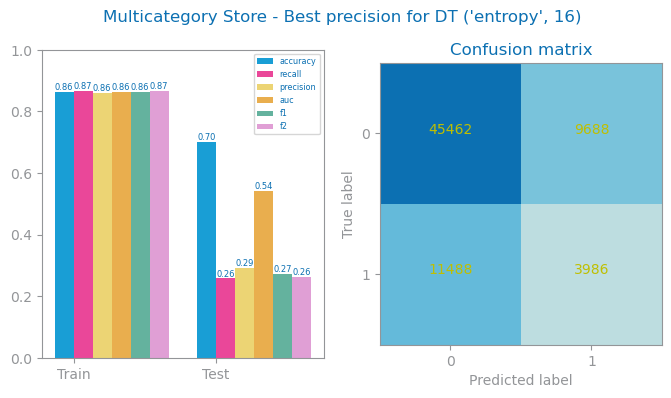

In [114]:
prd_trn: array = best_model_prec.predict(trnX)
prd_tst: array = best_model_prec.predict(tstX)
figure()
plot_evaluation_results(prec_params, trnY, prd_trn, tstY, prd_tst, labels, file_tag=file_tag)
savefig(f'images/{file_tag}_dt_{prec_params["name"]}_best_{prec_params["metric"]}_eval.png')
show()

We aim to achieve the minimum number of false positives while maintaining a high number of true positives. This enable us to effectively target customers who are likely to purchase (Tru positives). And This approach also helps reduce the budget spent on users we believed would buy but ultimately do not (False Positives). We tested three Gini values: 2, 6, 12 and 16. The Gini value of 6 provided the lowest number of false positives with a am moderate level of true positives, resulting in the high precision while still maintaining a high recall score.

-> -> Precision DT best with entropy and d=6

# f2

## f2 study

In [162]:
d_max_eval= 30

DT best with gini and d=6


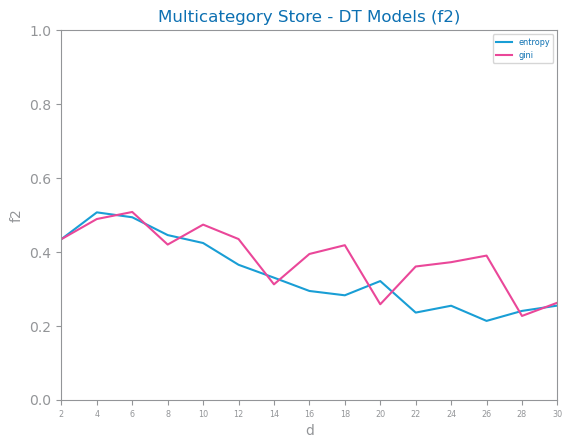

In [160]:
best_model_f2, f2_params = trees_study(trnX, trnY, tstX, tstY, d_max=d_max_eval, metric='f2', file_tag=file_tag)
savefig(f'images/{file_tag}_dt_{f2_params["metric"]}_study.png')
show()

## evaluate f2

<Figure size 640x480 with 0 Axes>

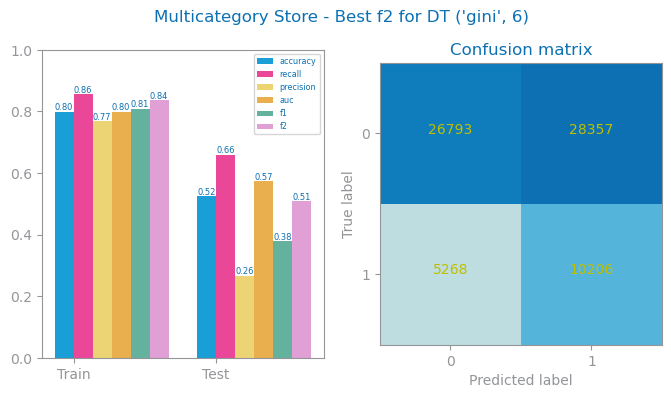

In [161]:
prd_trn: array = best_model_f2.predict(trnX)
prd_tst: array = best_model_f2.predict(tstX)
figure()
plot_evaluation_results(f2_params, trnY, prd_trn, tstY, prd_tst, labels, file_tag=file_tag)
savefig(f'images/{file_tag}_dt_{f2_params["name"]}_best_{f2_params["metric"]}_eval.png')
show()

We aim to achieve the minimum number of false positives while maintaining a high number of true positives. This enable us to effectively target customers who are likely to purchase (Tru positives). And This approach also helps reduce the budget spent on users we believed would buy but ultimately do not (False Positives). We tested three Gini values: 6 and 8. The Gini value of 6 provided the lowest number of false positives with a high level of true positives, resulting in the highest precision and laso highest recall score.

-> f2 DT best with entropy and d=6

## f2 Variables importance

# IF YOU HAVE AN ERROR YOU MAY NEED TO INSTALL GRAPHVIZ

1. open conda terminal
2. conda install graphviz

### f2 tree evaluation

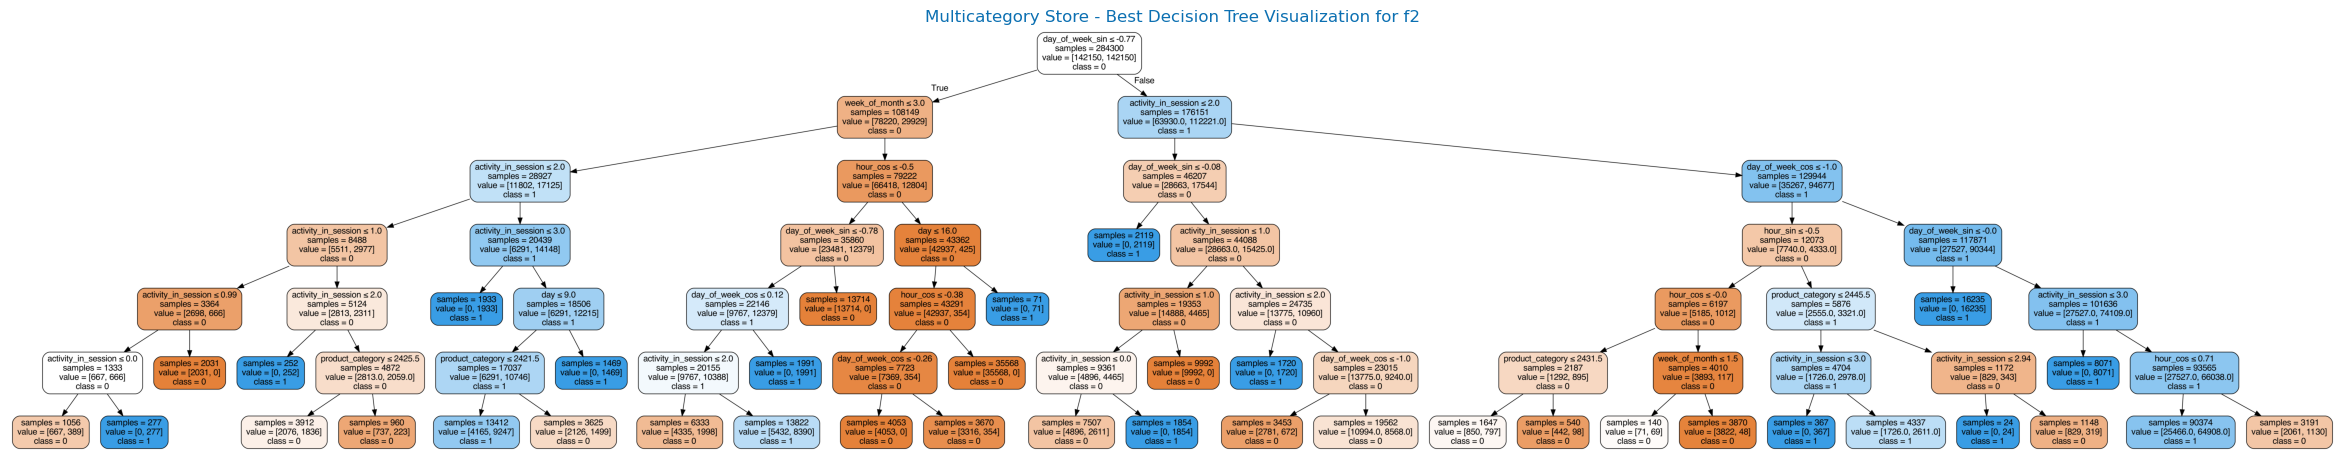

In [173]:
from sklearn.tree import export_graphviz
from matplotlib.pyplot import imread, imshow, axis, title
from subprocess import call

tree_filename: str = f"images/{file_tag}_dt_{f2_params['metric']}_best_tree"
max_depth2show = 8
st_labels: list[str] = [str(value) for value in labels]

dot_data: str = export_graphviz(
    best_model_f2,
    out_file=tree_filename + ".dot",
    max_depth=max_depth2show,
    feature_names=vars,
    class_names=st_labels,
    filled=True,
    rounded=True,
    impurity=False,
    special_characters=True,
    precision=2,
)
# Convert to png
call(
    ["dot", "-Tpng", tree_filename + ".dot", "-o", tree_filename + ".png", "-Gdpi=600"]
)

figure(figsize=(30, 34))
imshow(imread(tree_filename + ".png"))
title(f'{file_tag} - Best Decision Tree Visualization for {f2_params['metric']}')
savefig(f'images/{file_tag}_dt_{f2_params["name"]}_best_tree_{f2_params["metric"]}_eval.png')
axis("off")
show()

## f2 simpler tree

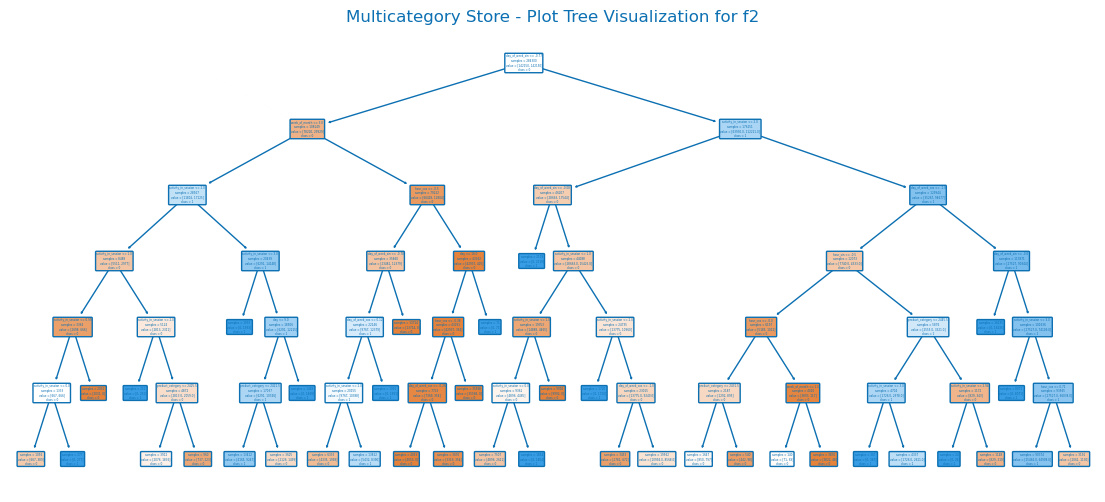

In [174]:
from sklearn.tree import plot_tree
from matplotlib.pyplot import title

figure(figsize=(14, 6))
plot_tree(
    best_model_f2,
    max_depth=max_depth2show,
    feature_names=vars,
    class_names=st_labels,
    filled=True,
    rounded=True,
    impurity=False,
    precision=2,
)
savefig(tree_filename + "_simple.png")
title(f'{file_tag} - Plot Tree Visualization for {f2_params['metric']}')

show()

# f2 Feature Importances

1. day_of_week_sin (0.4005414560049823)
2. activity_in_session (0.28531638509344653)
3. week_of_month (0.11979225482101075)
4. hour_cos (0.08582338485248743)
5. day_of_week_cos (0.07377286017550755)
6. hour_sin (0.01474960411953119)
7. product_category (0.012309212439919616)
8. day (0.007694842493114698)
9. brand_value (0.0)
10. price (0.0)
11. category_code_lvl_2 (0.0)
12. category_code_lvl_1 (0.0)


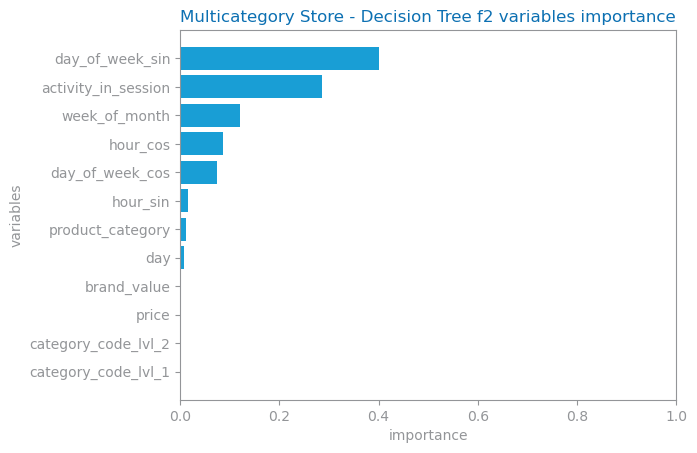

In [175]:
from numpy import argsort
from dslabs_functions import plot_horizontal_bar_chart

importances = best_model_f2.feature_importances_
indices: list[int] = argsort(importances)[::-1]
elems: list[str] = []
imp_values: list[float] = []
for f in range(len(vars)):
    elems += [vars[indices[f]]]
    imp_values += [importances[indices[f]]]
    print(f"{f+1}. {elems[f]} ({importances[indices[f]]})")

figure()
plot_horizontal_bar_chart(
    elems,
    imp_values,
    title=f"{file_tag} - Decision Tree {f2_params['metric']} variables importance",
    xlabel="importance",
    ylabel="variables",
    percentage=True,
)
savefig(f"images/{file_tag}_dt_{f2_params['metric']}_vars_ranking.png")
show()

Analysis:

In both evaluations day_of_week_sin and activity_in_session are by far the most important variables. For F2, week For F2, hour_cos variables is also very important.

# f2 Overfitting

In [187]:
d_max_eval=30

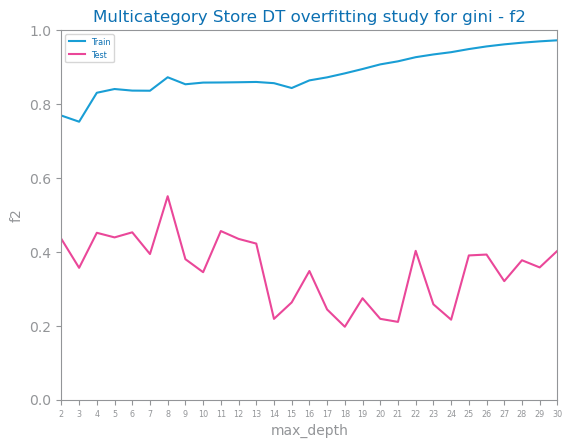

In [188]:
crit: Literal["entropy", "gini"] = f2_params["params"][0]
d_max = d_max_eval
depths: list[int] = [i for i in range(2, d_max + 1, 1)]
y_tst_values: list[float] = []
y_trn_values: list[float] = []
eval_metric = f2_params['metric']
for d in depths:
    clf = DecisionTreeClassifier(max_depth=d, criterion=crit, min_impurity_decrease=0)
    clf.fit(trnX, trnY)
    prd_tst_Y: array = clf.predict(tstX)
    prd_trn_Y: array = clf.predict(trnX)
    y_tst_values.append(CLASS_EVAL_METRICS[eval_metric](tstY, prd_tst_Y))
    y_trn_values.append(CLASS_EVAL_METRICS[eval_metric](trnY, prd_trn_Y))

figure()
plot_multiline_chart(
    depths,
    {"Train": y_trn_values, "Test": y_tst_values},
    title=f"{file_tag} DT overfitting study for {crit} - {f2_params['metric']}",
    xlabel="max_depth",
    ylabel=str(f2_params['metric']),
    percentage=True,
)
savefig(f"images/{file_tag}_dt_{f2_params['metric']}_overfitting.png")

# Precision - Variables Importance

## precision tree evaluation

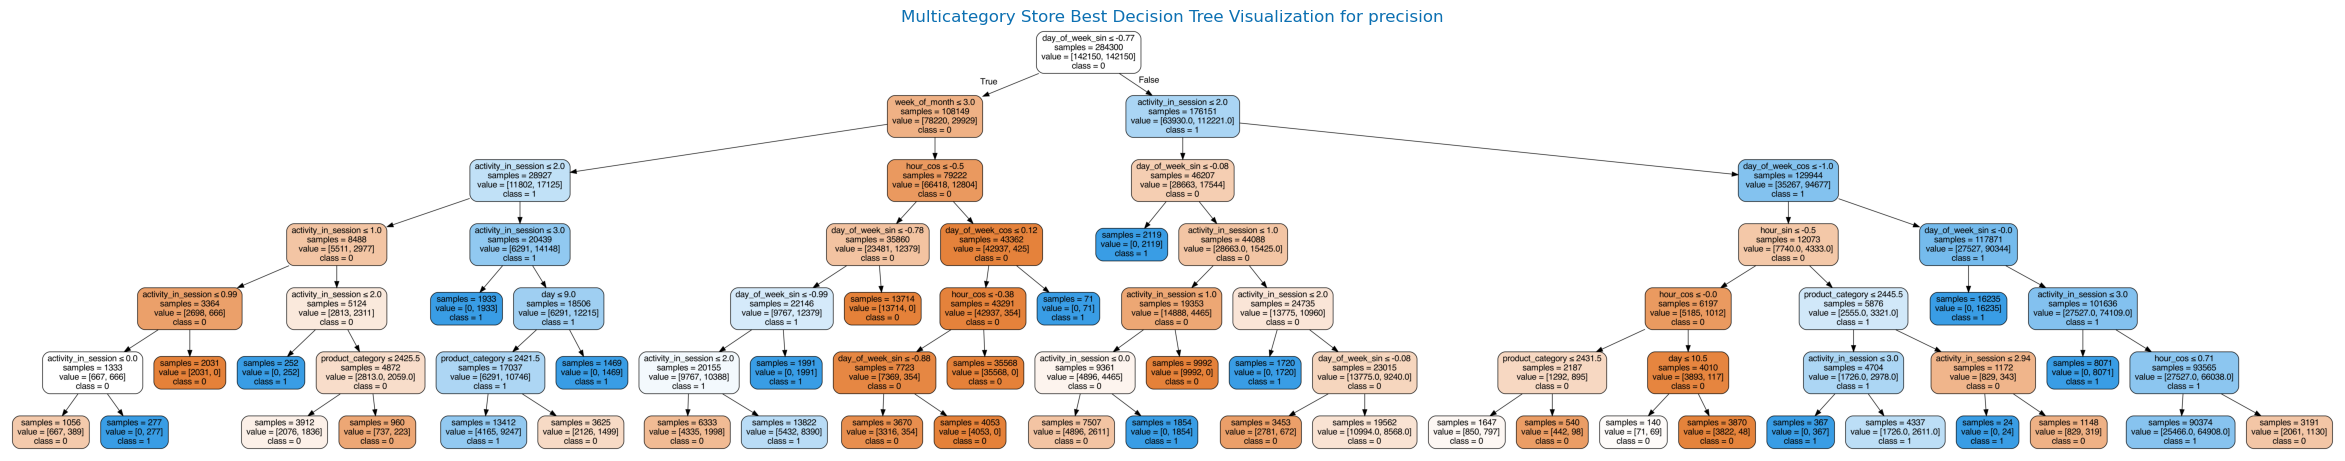

In [181]:
from sklearn.tree import export_graphviz
from matplotlib.pyplot import imread, imshow, axis, title
from subprocess import call

tree_filename: str = f"images/{file_tag}_dt_{prec_params['metric']}_best_tree"
max_depth2show = 8
st_labels: list[str] = [str(value) for value in labels]

dot_data: str = export_graphviz(
    best_model_prec,
    out_file=tree_filename + ".dot",
    max_depth=max_depth2show,
    feature_names=vars,
    class_names=st_labels,
    filled=True,
    rounded=True,
    impurity=False,
    special_characters=True,
    precision=2,
)
# Convert to png
call(
    ["dot", "-Tpng", tree_filename + ".dot", "-o", tree_filename + ".png", "-Gdpi=600"]
)

figure(figsize=(30, 24))
imshow(imread(tree_filename + ".png"))
title(f'{file_tag} Best Decision Tree Visualization for {prec_params['metric']}')
savefig(f'images/{file_tag}_dt_{prec_params["name"]}_best_tree_{prec_params["metric"]}_eval.png')

axis("off")
show()

## precision simple tree

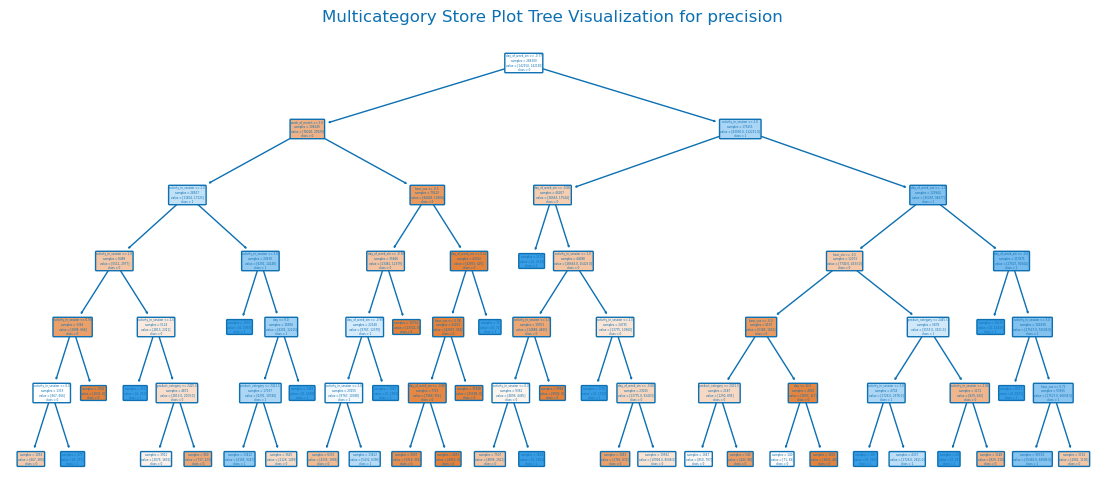

In [182]:
from sklearn.tree import plot_tree

figure(figsize=(14, 6))
plot_tree(
    best_model_prec,
    max_depth=max_depth2show,
    feature_names=vars,
    class_names=st_labels,
    filled=True,
    rounded=True,
    impurity=False,
    precision=2,
)
savefig(tree_filename + "_simple.png")
title(f'{file_tag} Plot Tree Visualization for {prec_params['metric']}')

show()

## precision feature importance

1. day_of_week_sin (0.4192324318957462)
2. activity_in_session (0.2853163850934465)
3. week_of_month (0.11884787347497558)
4. hour_cos (0.08582338485248742)
5. day_of_week_cos (0.05719325206030287)
6. hour_sin (0.014749604119531188)
7. product_category (0.012309212439919615)
8. day (0.0065278560635905584)
9. brand_value (0.0)
10. price (0.0)
11. category_code_lvl_2 (0.0)
12. category_code_lvl_1 (0.0)


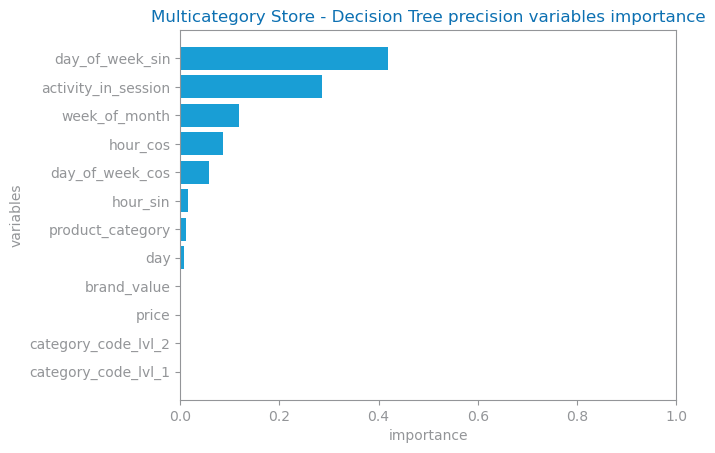

In [183]:
from numpy import argsort
from dslabs_functions import plot_horizontal_bar_chart

importances = best_model_prec.feature_importances_
indices: list[int] = argsort(importances)[::-1]
elems: list[str] = []
imp_values: list[float] = []
for f in range(len(vars)):
    elems += [vars[indices[f]]]
    imp_values += [importances[indices[f]]]
    print(f"{f+1}. {elems[f]} ({importances[indices[f]]})")

figure()
plot_horizontal_bar_chart(
    elems,
    imp_values,
    title=f"{file_tag} - Decision Tree {prec_params['metric']} variables importance",
    xlabel="importance",
    ylabel="variables",
    percentage=True,
)
savefig(f"images/{file_tag}_dt_{prec_params['metric']}_vars_ranking.png")
show()

## precision overfitting

In [185]:
d_max_eval= 30

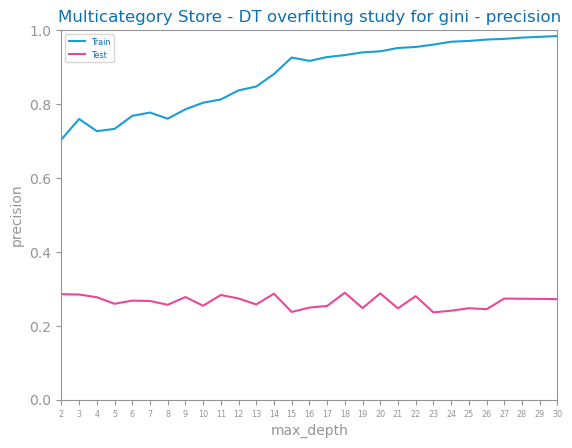

In [189]:
crit: Literal["entropy", "gini"] = prec_params["params"][0]
d_max = d_max_eval
depths: list[int] = [i for i in range(2, d_max + 1, 1)]
y_tst_values: list[float] = []
y_trn_values: list[float] = []
eval_metric = prec_params['metric']
for d in depths:
    clf = DecisionTreeClassifier(max_depth=d, criterion=crit, min_impurity_decrease=0)
    clf.fit(trnX, trnY)
    prd_tst_Y: array = clf.predict(tstX)
    prd_trn_Y: array = clf.predict(trnX)
    y_tst_values.append(CLASS_EVAL_METRICS[eval_metric](tstY, prd_tst_Y))
    y_trn_values.append(CLASS_EVAL_METRICS[eval_metric](trnY, prd_trn_Y))

figure()
plot_multiline_chart(
    depths,
    {"Train": y_trn_values, "Test": y_tst_values},
    title=f"{file_tag} - DT overfitting study for {crit} - {prec_params['metric']}",
    xlabel="max_depth",
    ylabel=str(prec_params['metric']),
    percentage=True,
)
savefig(f"images/{file_tag}_dt_{prec_params['metric']}_overfitting.png")

# Analysis


We aim to achieve the minimum number of false positives while maintaining a high number of true positives. This enable us to effectively target customers who are likely to purchase (Tru positives). And This approach also helps reduce the budget spent on users we believed would buy but ultimately do not (False Positives). We tested three Gini values: 2, 6, 12 and 16. The Gini value of 6 provided the lowest number of false positives with a am moderate level of true positives, resulting in the high precision while still maintaining a high recall score.


Dataset used:
- Complete dataset from balancing step was used.


Precision/recall/ f2 study:
- Precision DT best with entropy and d=6
- Precision F2 best with entropy and d=6


Several gini values were tested for both precision and f2, and for both models the best precision and best f2 scores were obtained with entropy and d=6. The Gini value of 6 provided the lowest number of false positives with a am moderate level of true positives. Compating best performance precision vs best perofm f2, we get the highest level of precision (29%), meaning less False positves than f2 best model, and also maintaining a high number of True positives, with a recall of 47. Despist having more recall on f2 (66%, the best balanced score between false positves and true positives is obtain in best precision model. 



Variables importance:
For both precision and f2, these are the most important values:
- day_of_week_sin (0.40)
- activity_in_session (0.285)
- week_of_month (0.119)
- hour_cos (0.085)
- day_of_week_cos (0.073)
- hour_sin (0.014)
- product_category (0.0123)
- day (0.00769)

- For both f2 and precision best models, day_of_week_sin and activity_in_session are by far the most relevant variable,s thats why they also appeared in the first nos da best arvore de decisao para f2 and precisiion.Foloowing this, week_of_month, hour_cos and day_ofwee_cos are also relevant variables that appear distribuidos pelos  primeiros ramos da melhor avore de mabos os modelos


Overfitting:
- Em F2, há um overffiting alto que é evidente a partir do no 9, em que podemos ver que no train a precision começa a aumentar consideravelmente, e esta estagna , ou seja deixa de subir de ofrma contante no dataset de train. Em relação à precision, conseguimos ver que tema´bem temos overfitting a partir do no 9, e o comportamento do overfitting é bastante identico ao do f2. Isto mostra que o modelo está muito adaptado ao dataset de train, e está com dificuldade em generalizar para dados de teste que nunca viu. O facto de termos uma arvore complexa e com grande profundade, contribui para o overfitting depois está a criar muito detalhe com base no que ve no train, que não é necessariamente o que depois vai ver no test. 

best tree:
- Both f2 and precision trees have the same level of depth (6), but precision tree, should be the main one to adopt has it provided higher precision as we saw in the evaluation.


## Extended analysis

- Several Gini values were tested for both precision and F2 scores, with the best results for both models achieved using entropy and Gini = 6. This Gini value produced the lowest number of false positives and a moderate level of true positives. Comparing the best performance of precision and F2, the highest precision was 29%, resulting in fewer false positives than the F2 model, while maintaining a high recall of 47%. Despite the F2 model showing higher recall at 66%, the best balance between false positives and true positives was obtained with the precision model.

- Regarding variable importance, the most relevant features identified were day_of_week_sin, which had the highest importance score of (~41%), followed by activity_in_session at (~28%). Other significant variables included week_of_month, hour_cos, and day_of_week_cos.

- In terms of overfitting, the F2 model exhibited high overfitting, evident from node 9, where precision began a considerable increase in the training set, while in the test, it did not increase and remained stable at previous values. A similar pattern of overfitting was observed in the precision model, indicating that the model was overly fitted to the training data and struggled to generalize to unseen test data. The complexity and depth of the tree (depth=6) contributed to this overfitting by capturing too many details specific to the training data, which may not apply to the test data.

- Both the F2 and precision trees have the same depth of 6, but the precision tree should be the preferred choice as it provides higher precision, as noted in the evaluation

## Short analysis for the report:
- Testing various Gini values revealed that Gini = 6 yielded the best precision (29%) and F2 scores, with fewer false positives and a moderate number of true positives. Key variables included day_of_week_sin and activity_in_session. Both models showed overfitting from node 9. The precision and f2 tree, both have the same depth of 6, but precision tree is preferred due to its higher combined score of precision and recall.